In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

C:\Users\Rajit_Sanghvi\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Rajit_Sanghvi\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Rajit_Sanghvi\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)

Bad key "text.kerning_factor" on line 4 in
C:\Users\Rajit_Sanghvi\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
tf.__version__

'2.6.2'

# DATA CREATION

In [4]:
# Inputs range
obs = 10000

# Stock price
S_min = 1
S_max = 1000

# strike (exercise) price as a percentage of stock price
K_min = 0.8 # this is defined as a multiplying factor on the stock price
K_max = 1.2 # this is defined as a multiplying factor on the stock price

# time of expiration
t_min = 0.1
t_max = 10

# interest free rate
r_min = 0.001
r_max = 0.1

# standard deviation
sd_min = 0.001
sd_max = 0.3

In [5]:
# Random normal distribution

data = pd.DataFrame( columns = ["S0", "K", "t", "r", "sd"])
data["S0"] = np.random.uniform(low=S_min, high=S_max, size=obs)
data["K"] = np.multiply(np.random.uniform(low=K_min, high=K_max, size=obs), data["S0"])
data["t"] = np.random.uniform(low=t_min, high=t_max, size=obs)
data["r"] = np.random.uniform(low=r_min, high=r_max, size=obs)
data["sd"] = np.random.uniform(low=sd_min, high=sd_max, size=obs)
print(data)

              S0           K         t         r        sd
0      36.553945   37.336555  6.842521  0.011777  0.031426
1     503.931201  507.303276  6.991406  0.063457  0.288755
2      47.178967   55.096273  2.553145  0.004705  0.257750
3      17.503096   17.303033  0.498071  0.008077  0.093400
4     106.049460   92.559282  2.356315  0.004654  0.234851
...          ...         ...       ...       ...       ...
9995  942.423134  829.086430  8.542538  0.070767  0.115142
9996  195.662083  190.574853  6.951532  0.059254  0.064307
9997  316.864342  294.497904  1.386385  0.035759  0.201916
9998  418.291649  453.986098  8.242503  0.041185  0.150740
9999  398.656317  447.749955  9.669201  0.008350  0.181298

[10000 rows x 5 columns]


In [6]:
data.describe()

,S0,K,t,r,sd
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,501.143988,500.400456,5.062557,0.051119,0.151126
std,287.279001,294.072711,2.871117,0.028722,0.086409
min,1.021458,1.019274,0.101154,0.001006,0.001013
25%,250.307662,248.113661,2.565950,0.026060,0.076285
50%,504.616588,494.542756,5.097472,0.051392,0.152237
75%,751.382197,742.078700,7.554446,0.076450,0.223762
max,999.974699,1195.257924,9.998478,0.099980,0.299968


In [7]:
# B-S model
data["d1"] = (np.log(data["S0"]/data["K"]) + (data['r']+0.5*data["sd"]**2)*data["t"]) / (data["sd"]*data["t"]**0.5)
data["d2"]  = data["d1"] - data["sd"]*data["t"]**0.5
data["c"] = data["S0"]*norm.cdf(data["d1"]) - data["K"]*np.exp(-data["r"]*data["t"])*norm.cdf(data["d2"])
data["c"] = (1+np.random.standard_normal(size=len(data["c"]))/20)*data["c"] # adding noise to c (68% of times +/-5%; 95% of times +/-10%; 99.7% of times +/-10%; )
data.drop(["d1", "d2"],axis=1, inplace=True)
data

,S0,K,t,r,sd,c
0,36.553945,37.336555,6.842521,0.011777,0.031426,2.419413
1,503.931201,507.303276,6.991406,0.063457,0.288755,212.053919
2,47.178967,55.096273,2.553145,0.004705,0.257750,5.231119
3,17.503096,17.303033,0.498071,0.008077,0.093400,0.632553
4,106.049460,92.559282,2.356315,0.004654,0.234851,21.869057
...,...,...,...,...,...,...
9995,942.423134,829.086430,8.542538,0.070767,0.115142,495.238016
9996,195.662083,190.574853,6.951532,0.059254,0.064307,70.620009
9997,316.864342,294.497904,1.386385,0.035759,0.201916,49.769384
9998,418.291649,453.986098,8.242503,0.041185,0.150740,116.315996


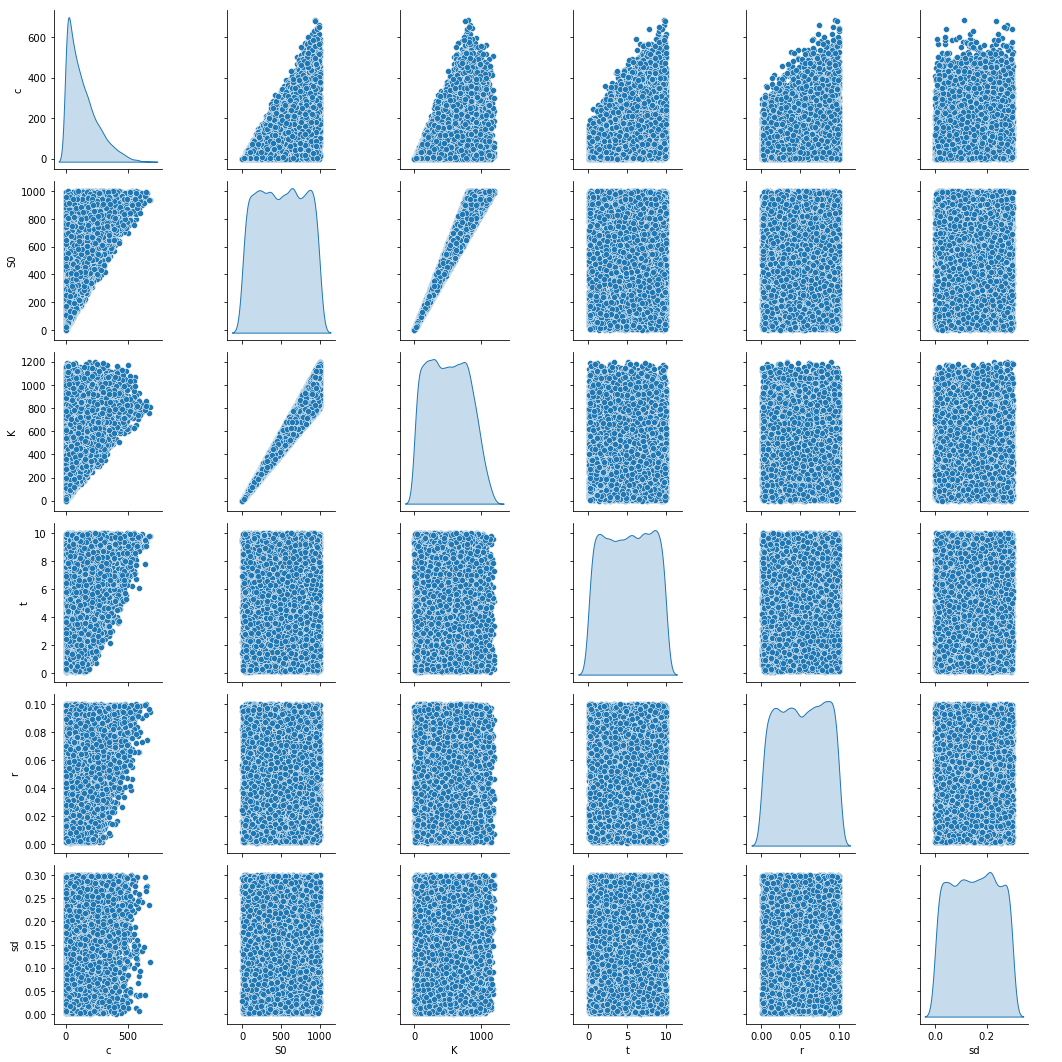

In [8]:
sns.pairplot(data[['c', 'S0', 'K', 't', 'r', 'sd']], diag_kind='kde')

# Pre-processing

In [45]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(data, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

df_train_full = df_train_full.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.c.values
y_val = df_val.c.values
y_test = df_test.c.values

del df_train['c']
del df_val['c']
del df_test['c']

In [46]:
df_train.shape, df_val.shape, df_test.shape

((6000, 5), (2000, 5), (2000, 5))

In [47]:
df_train

,S0,K,t,r,sd
0,762.563140,834.021566,4.913214,0.044639,0.191448
1,430.051384,367.596278,6.054607,0.048656,0.006658
2,304.912900,363.696671,4.613061,0.058176,0.125247
3,223.118817,261.307019,5.840003,0.083041,0.034097
4,673.147676,664.623738,0.647242,0.054302,0.262125
...,...,...,...,...,...
5995,943.319995,1007.517264,5.340800,0.039648,0.187022
5996,993.737103,821.120223,8.889555,0.038227,0.299510
5997,941.749569,991.971497,8.610219,0.096400,0.276055
5998,180.870340,175.415638,5.877034,0.090439,0.062797


In [48]:
y_train

array([180.98773282, 157.71299704,  48.84181579, ..., 558.12731303,
        75.75986999,  71.60089761])

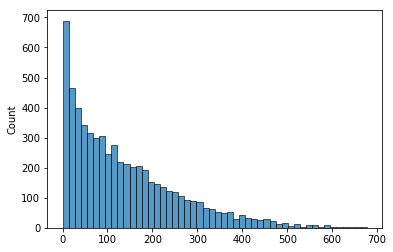

In [49]:
sns.histplot(y_train, bins = 50)

In [52]:
# Normalization

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(df_train)
X_val = scaler.fit_transform(df_val)
X_test = scaler.fit_transform(df_test)

In [53]:
X_train

array([[ 0.90056778,  1.12816229, -0.05200161, -0.22434219,  0.46684038],
       [-0.25775339, -0.4611471 ,  0.34477313, -0.08521361, -1.67531193],
       [-0.6936795 , -0.47443472, -0.15634165,  0.24445957, -0.30058445],
       ...,
       [ 1.52477258,  1.6663649 ,  1.23316302,  1.56820724,  1.44763714],
       [-1.1257879 , -1.1159883 ,  0.28304468,  1.36176999, -1.02453312],
       [-0.6043897 , -0.75653792, -1.44444928,  0.74956138, -0.06079482]])

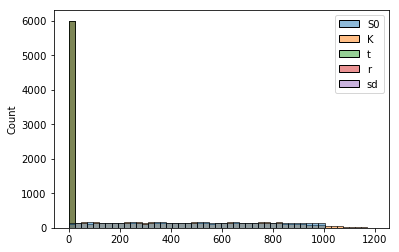

In [54]:
sns.histplot(df_train, bins = 50)

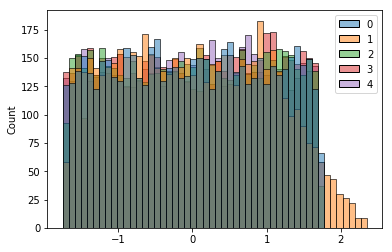

In [55]:
sns.histplot(X_train, bins = 50)

In [56]:
X_train.shape

(6000, 5)

# Linear Regression

In [57]:
linear_model = tf.keras.Sequential([
   layers.Dense(units=1, input_shape=(5,)) #linear regression layer (units = 1)
])

linear_model.compile(
                    optimizer=tf.optimizers.Adam(learning_rate=0.1),
                    loss='mean_absolute_error')

linear_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [58]:
history = linear_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 100)

Epoch 1/100
188/188 [==============================] - 1s 2ms/step - loss: 127.2043 - val_loss: 116.2395
Epoch 2/100
188/188 [==============================] - 0s 1ms/step - loss: 110.2361 - val_loss: 100.0904
Epoch 3/100
188/188 [==============================] - 0s 1ms/step - loss: 95.0581 - val_loss: 85.7324
Epoch 4/100
188/188 [==============================] - 0s 1ms/step - loss: 81.6239 - val_loss: 73.3322
Epoch 5/100
188/188 [==============================] - 0s 1ms/step - loss: 70.2650 - val_loss: 63.5655
Epoch 6/100
188/188 [==============================] - 0s 1ms/step - loss: 61.5427 - val_loss: 56.5272
Epoch 7/100
188/188 [==============================] - 0s 1ms/step - loss: 55.5261 - val_loss: 52.0306
Epoch 8/100
188/188 [==============================] - 0s 1ms/step - loss: 51.7694 - val_loss: 49.3826
Epoch 9/100
188/188 [==============================] - 0s 1ms/step - loss: 49.4568 - val_loss: 47.6337
Epoch 10/100
188/188 [==============================] - 0s 1ms/step -

188/188 [==============================] - 0s 1ms/step - loss: 36.5404 - val_loss: 36.1523
Epoch 80/100
188/188 [==============================] - 0s 1ms/step - loss: 36.5304 - val_loss: 36.2179
Epoch 81/100
188/188 [==============================] - 0s 1ms/step - loss: 36.5181 - val_loss: 36.2015
Epoch 82/100
188/188 [==============================] - 0s 1ms/step - loss: 36.5148 - val_loss: 36.2233
Epoch 83/100
188/188 [==============================] - 0s 1ms/step - loss: 36.5271 - val_loss: 36.2225
Epoch 84/100
188/188 [==============================] - 0s 1ms/step - loss: 36.5215 - val_loss: 36.2279
Epoch 85/100
188/188 [==============================] - 0s 1ms/step - loss: 36.5333 - val_loss: 36.2279
Epoch 86/100
188/188 [==============================] - 0s 1ms/step - loss: 36.5248 - val_loss: 36.2253
Epoch 87/100
188/188 [==============================] - 0s 1ms/step - loss: 36.5190 - val_loss: 36.2139
Epoch 88/100
188/188 [==============================] - 0s 1ms/step - loss: 3

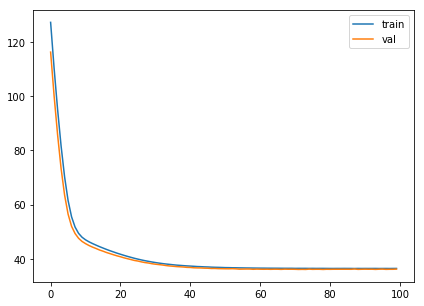

In [60]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

In [67]:
# Coefficients
linear_model.layers[0].kernel.numpy()

array([[ 228.29984 ],
       [-157.81758 ],
       [  49.993786],
       [  35.025543],
       [  20.737984]], dtype=float32)

# Deeper neural network

In [70]:
model = tf.keras.Sequential([
   layers.Dense(units=64, activation='relu', input_shape=(5,)),
   layers.Dense(units=32, activation='relu'),
   layers.Dense(units=16, activation='relu'),
   layers.Dense(units=8, activation='relu'),
   layers.Dense(units=1)
])

model.compile(
              optimizer=tf.optimizers.Adam(learning_rate=0.1),
              loss='mean_absolute_error')

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 3,137
Trainable params: 3,137
Non-trainable params: 0
_________________________________________________________________


In [71]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 100)

Epoch 1/100
188/188 [==============================] - 1s 2ms/step - loss: 28.3866 - val_loss: 12.1311
Epoch 2/100
188/188 [==============================] - 0s 2ms/step - loss: 17.4938 - val_loss: 12.0214
Epoch 3/100
188/188 [==============================] - 0s 1ms/step - loss: 13.8446 - val_loss: 16.2991
Epoch 4/100
188/188 [==============================] - 0s 1ms/step - loss: 12.6344 - val_loss: 25.8545
Epoch 5/100
188/188 [==============================] - 0s 2ms/step - loss: 14.5082 - val_loss: 11.8081
Epoch 6/100
188/188 [==============================] - 0s 2ms/step - loss: 13.8568 - val_loss: 13.6388
Epoch 7/100
188/188 [==============================] - 0s 1ms/step - loss: 12.1181 - val_loss: 9.4850
Epoch 8/100
188/188 [==============================] - 0s 1ms/step - loss: 12.1057 - val_loss: 13.7191
Epoch 9/100
188/188 [==============================] - 0s 1ms/step - loss: 11.0182 - val_loss: 9.5253
Epoch 10/100
188/188 [==============================] - 0s 1ms/step - loss:

188/188 [==============================] - 0s 1ms/step - loss: 14.2225 - val_loss: 10.2047
Epoch 81/100
188/188 [==============================] - 0s 1ms/step - loss: 14.0366 - val_loss: 10.7210
Epoch 82/100
188/188 [==============================] - 0s 1ms/step - loss: 11.5928 - val_loss: 13.9324
Epoch 83/100
188/188 [==============================] - 0s 1ms/step - loss: 9.5570 - val_loss: 8.5269
Epoch 84/100
188/188 [==============================] - 0s 1ms/step - loss: 9.0430 - val_loss: 18.7028
Epoch 85/100
188/188 [==============================] - 0s 1ms/step - loss: 9.3608 - val_loss: 8.2130
Epoch 86/100
188/188 [==============================] - 0s 1ms/step - loss: 10.8135 - val_loss: 7.6595
Epoch 87/100
188/188 [==============================] - 0s 1ms/step - loss: 9.6179 - val_loss: 10.2406
Epoch 88/100
188/188 [==============================] - 0s 1ms/step - loss: 10.8169 - val_loss: 10.0722
Epoch 89/100
188/188 [==============================] - 0s 1ms/step - loss: 10.4202 

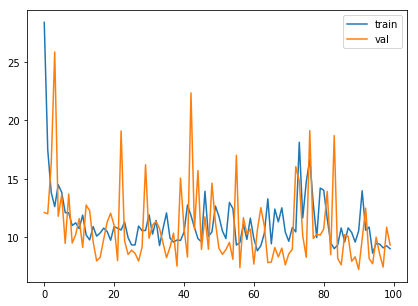

In [72]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

In [83]:
results_df = pd.DataFrame(index=['Mean absolute error'])
results_df['linear_model'] = [linear_model.evaluate(X_test, y_test)]
results_df['DNN_model'] = [model.evaluate(X_test, y_test)]
results_df.T

63/63 [==============================] - 0s 1ms/step - loss: 9.1496


,Mean absolute error
linear_model,36.892036
DNN_model,9.149607


# Learning rate tuning

In [84]:
def make_DNN_model(learning_rate):
    
    model = tf.keras.Sequential([
                                   layers.Dense(units=64, activation='relu', input_shape=(5,)),
                                   layers.Dense(units=32, activation='relu'),
                                   layers.Dense(units=16, activation='relu'),
                                   layers.Dense(units=8, activation='relu'),
                                   layers.Dense(units=1)
                                ])

    model.compile(
              optimizer=tf.optimizers.Adam(learning_rate),
              loss='mean_absolute_error')

    return model

In [86]:
learning_rate = [0.0001, 0.001, 0.01, 1, 10]
scores = {}

for lr in learning_rate:
    print(lr)
    
    model = make_DNN_model(lr)
    history =  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 100)
    scores[lr] = history.history
    
    print()
    print()

0.0001
Epoch 1/100
188/188 [==============================] - 1s 2ms/step - loss: 136.1258 - val_loss: 133.8190
Epoch 2/100
188/188 [==============================] - 0s 2ms/step - loss: 135.7699 - val_loss: 133.3532
Epoch 3/100
188/188 [==============================] - 0s 2ms/step - loss: 134.8115 - val_loss: 131.5722
Epoch 4/100
188/188 [==============================] - 0s 1ms/step - loss: 131.4983 - val_loss: 126.3223
Epoch 5/100
188/188 [==============================] - 0s 1ms/step - loss: 123.6609 - val_loss: 115.5685
Epoch 6/100
188/188 [==============================] - 0s 1ms/step - loss: 110.1597 - val_loss: 99.2234
Epoch 7/100
188/188 [==============================] - 0s 1ms/step - loss: 91.8241 - val_loss: 78.9664
Epoch 8/100
188/188 [==============================] - 0s 1ms/step - loss: 71.7277 - val_loss: 60.9874
Epoch 9/100
188/188 [==============================] - 0s 1ms/step - loss: 57.4107 - val_loss: 51.1212
Epoch 10/100
188/188 [==============================] -

188/188 [==============================] - 0s 1ms/step - loss: 10.3766 - val_loss: 10.6660
Epoch 80/100
188/188 [==============================] - 0s 1ms/step - loss: 10.3217 - val_loss: 10.4033
Epoch 81/100
188/188 [==============================] - 0s 1ms/step - loss: 10.2401 - val_loss: 10.5430
Epoch 82/100
188/188 [==============================] - 0s 1ms/step - loss: 10.1770 - val_loss: 10.3083
Epoch 83/100
188/188 [==============================] - 0s 1ms/step - loss: 10.1061 - val_loss: 10.3658
Epoch 84/100
188/188 [==============================] - 0s 2ms/step - loss: 10.0399 - val_loss: 10.3306
Epoch 85/100
188/188 [==============================] - 0s 1ms/step - loss: 10.0186 - val_loss: 10.2688
Epoch 86/100
188/188 [==============================] - 0s 1ms/step - loss: 9.9533 - val_loss: 10.1944
Epoch 87/100
188/188 [==============================] - 0s 1ms/step - loss: 9.9225 - val_loss: 10.2340
Epoch 88/100
188/188 [==============================] - 0s 1ms/step - loss: 9.8

188/188 [==============================] - 0s 1ms/step - loss: 6.4671 - val_loss: 7.0647
Epoch 60/100
188/188 [==============================] - 0s 1ms/step - loss: 6.3574 - val_loss: 6.5083
Epoch 61/100
188/188 [==============================] - 0s 1ms/step - loss: 6.3472 - val_loss: 7.7083
Epoch 62/100
188/188 [==============================] - 0s 1ms/step - loss: 6.3482 - val_loss: 6.6758
Epoch 63/100
188/188 [==============================] - 0s 2ms/step - loss: 6.4670 - val_loss: 8.7057
Epoch 64/100
188/188 [==============================] - 0s 2ms/step - loss: 6.5071 - val_loss: 7.3538
Epoch 65/100
188/188 [==============================] - 0s 1ms/step - loss: 6.3425 - val_loss: 6.7855
Epoch 66/100
188/188 [==============================] - 0s 1ms/step - loss: 6.2979 - val_loss: 7.5521
Epoch 67/100
188/188 [==============================] - 0s 1ms/step - loss: 6.3189 - val_loss: 7.3211
Epoch 68/100
188/188 [==============================] - 0s 1ms/step - loss: 6.3926 - val_loss: 

188/188 [==============================] - 0s 1ms/step - loss: 7.3725 - val_loss: 10.0248
Epoch 40/100
188/188 [==============================] - 0s 1ms/step - loss: 7.2819 - val_loss: 8.8484
Epoch 41/100
188/188 [==============================] - 0s 1ms/step - loss: 7.3781 - val_loss: 7.1358
Epoch 42/100
188/188 [==============================] - 0s 1ms/step - loss: 7.0539 - val_loss: 9.1074
Epoch 43/100
188/188 [==============================] - 0s 1ms/step - loss: 7.1374 - val_loss: 8.3049
Epoch 44/100
188/188 [==============================] - 0s 1ms/step - loss: 7.1059 - val_loss: 7.9854
Epoch 45/100
188/188 [==============================] - 0s 1ms/step - loss: 7.4652 - val_loss: 6.6691
Epoch 46/100
188/188 [==============================] - 0s 1ms/step - loss: 7.3298 - val_loss: 6.6285
Epoch 47/100
188/188 [==============================] - 0s 1ms/step - loss: 7.0856 - val_loss: 6.5538
Epoch 48/100
188/188 [==============================] - 0s 1ms/step - loss: 7.1158 - val_loss:

188/188 [==============================] - 0s 1ms/step - loss: 92.9995 - val_loss: 91.3487
Epoch 20/100
188/188 [==============================] - 0s 1ms/step - loss: 92.9894 - val_loss: 91.3904
Epoch 21/100
188/188 [==============================] - 0s 1ms/step - loss: 92.9406 - val_loss: 91.4352
Epoch 22/100
188/188 [==============================] - 0s 1ms/step - loss: 93.0440 - val_loss: 91.3030
Epoch 23/100
188/188 [==============================] - 0s 1ms/step - loss: 92.9744 - val_loss: 91.2986
Epoch 24/100
188/188 [==============================] - 0s 1ms/step - loss: 92.9733 - val_loss: 91.3352
Epoch 25/100
188/188 [==============================] - 0s 1ms/step - loss: 93.0109 - val_loss: 91.3673
Epoch 26/100
188/188 [==============================] - 0s 1ms/step - loss: 92.9859 - val_loss: 91.3015
Epoch 27/100
188/188 [==============================] - 0s 1ms/step - loss: 92.9991 - val_loss: 91.4038
Epoch 28/100
188/188 [==============================] - 0s 1ms/step - loss: 9

Epoch 98/100
188/188 [==============================] - 0s 1ms/step - loss: 92.9688 - val_loss: 91.3086
Epoch 99/100
188/188 [==============================] - 0s 1ms/step - loss: 92.9905 - val_loss: 91.3066
Epoch 100/100
188/188 [==============================] - 0s 1ms/step - loss: 93.0020 - val_loss: 91.3298


10
Epoch 1/100
188/188 [==============================] - 1s 2ms/step - loss: 18601264.0000 - val_loss: 91.8452
Epoch 2/100
188/188 [==============================] - 0s 1ms/step - loss: 93.3440 - val_loss: 92.7138
Epoch 3/100
188/188 [==============================] - 0s 1ms/step - loss: 93.3290 - val_loss: 91.3014
Epoch 4/100
188/188 [==============================] - 0s 1ms/step - loss: 93.1090 - val_loss: 93.0430
Epoch 5/100
188/188 [==============================] - 0s 1ms/step - loss: 93.3602 - val_loss: 92.3872
Epoch 6/100
188/188 [==============================] - 0s 1ms/step - loss: 93.2079 - val_loss: 91.3321
Epoch 7/100
188/188 [==============================] - 0s 

188/188 [==============================] - 0s 2ms/step - loss: 93.0781 - val_loss: 91.9425
Epoch 77/100
188/188 [==============================] - 0s 1ms/step - loss: 93.3413 - val_loss: 91.3735
Epoch 78/100
188/188 [==============================] - 0s 1ms/step - loss: 93.3677 - val_loss: 94.5071
Epoch 79/100
188/188 [==============================] - 0s 1ms/step - loss: 93.3222 - val_loss: 94.3796
Epoch 80/100
188/188 [==============================] - 0s 1ms/step - loss: 93.3737 - val_loss: 91.4822
Epoch 81/100
188/188 [==============================] - 0s 1ms/step - loss: 93.3911 - val_loss: 91.3744
Epoch 82/100
188/188 [==============================] - 0s 2ms/step - loss: 93.5521 - val_loss: 91.5777
Epoch 83/100
188/188 [==============================] - 0s 1ms/step - loss: 93.2422 - val_loss: 91.3003
Epoch 84/100
188/188 [==============================] - 0s 2ms/step - loss: 93.4111 - val_loss: 91.5410
Epoch 85/100
188/188 [==============================] - 0s 1ms/step - loss: 9

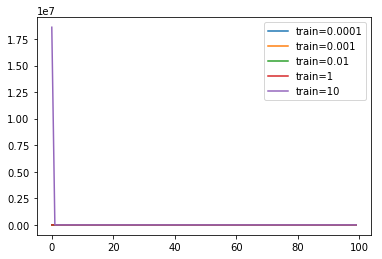

In [90]:
for lr, hist in scores.items():
    plt.plot(hist['loss'], label=('train=%s' % lr))
plt.legend()

In [95]:
del scores[10]

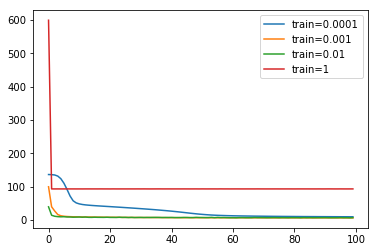

In [96]:
for lr, hist in scores.items():
    plt.plot(hist['loss'], label=('train=%s' % lr))
plt.legend()

In [97]:
del scores[1]

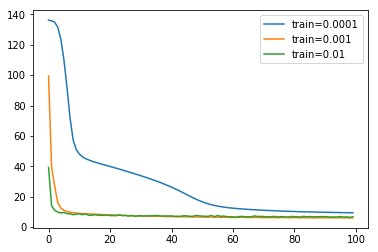

In [98]:
for lr, hist in scores.items():
    plt.plot(hist['loss'], label=('train=%s' % lr))
plt.legend()

In [99]:
# Learning_rate = 0.01

model = tf.keras.Sequential([
   layers.Dense(units=64, activation='relu', input_shape=(5,)),
   layers.Dense(units=32, activation='relu'),
   layers.Dense(units=16, activation='relu'),
   layers.Dense(units=8, activation='relu'),
   layers.Dense(units=1)
])

model.compile(
              optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss='mean_absolute_error')

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 64)                384       
_________________________________________________________________
dense_44 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_45 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_46 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 9         
Total params: 3,137
Trainable params: 3,137
Non-trainable params: 0
_________________________________________________________________


In [100]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 100)

Epoch 1/100
188/188 [==============================] - 1s 2ms/step - loss: 48.7721 - val_loss: 19.9065
Epoch 2/100
188/188 [==============================] - 0s 1ms/step - loss: 14.2128 - val_loss: 13.5310
Epoch 3/100
188/188 [==============================] - 0s 1ms/step - loss: 11.7298 - val_loss: 11.8579
Epoch 4/100
188/188 [==============================] - 0s 1ms/step - loss: 11.0225 - val_loss: 8.9874
Epoch 5/100
188/188 [==============================] - 0s 1ms/step - loss: 10.5507 - val_loss: 9.1751
Epoch 6/100
188/188 [==============================] - 0s 1ms/step - loss: 9.7557 - val_loss: 9.3194
Epoch 7/100
188/188 [==============================] - 0s 1ms/step - loss: 9.3385 - val_loss: 9.1682
Epoch 8/100
188/188 [==============================] - 0s 1ms/step - loss: 9.1515 - val_loss: 10.6156
Epoch 9/100
188/188 [==============================] - 0s 1ms/step - loss: 8.9812 - val_loss: 7.9764
Epoch 10/100
188/188 [==============================] - 0s 1ms/step - loss: 8.5312

188/188 [==============================] - 0s 1ms/step - loss: 6.7477 - val_loss: 7.4624
Epoch 82/100
188/188 [==============================] - 0s 1ms/step - loss: 6.4903 - val_loss: 7.2225
Epoch 83/100
188/188 [==============================] - 0s 1ms/step - loss: 6.6997 - val_loss: 6.8930
Epoch 84/100
188/188 [==============================] - 0s 2ms/step - loss: 6.7985 - val_loss: 7.5966
Epoch 85/100
188/188 [==============================] - 0s 1ms/step - loss: 6.4412 - val_loss: 8.9579
Epoch 86/100
188/188 [==============================] - 0s 2ms/step - loss: 6.6941 - val_loss: 7.2722
Epoch 87/100
188/188 [==============================] - 0s 1ms/step - loss: 6.6768 - val_loss: 8.0600
Epoch 88/100
188/188 [==============================] - 0s 2ms/step - loss: 6.6347 - val_loss: 6.7987
Epoch 89/100
188/188 [==============================] - 0s 1ms/step - loss: 6.4874 - val_loss: 6.3844
Epoch 90/100
188/188 [==============================] - 0s 1ms/step - loss: 6.5351 - val_loss: 

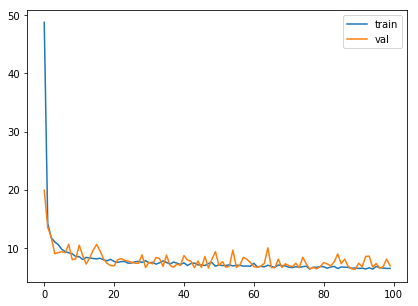

In [101]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

In [102]:
results_df['Tuned_DNN_model'] = [model.evaluate(X_test, y_test)]
results_df.T

63/63 [==============================] - 0s 1ms/step - loss: 7.2637


,Mean absolute error
linear_model,36.892036
DNN_model,9.149607
Tuned_DNN_model,7.263657


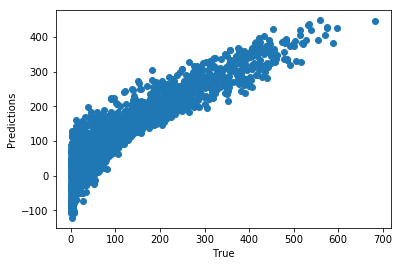

In [108]:
# Predicting test data for linear model

pred = linear_model.predict(X_test).flatten()

# Plot predicted vs true labels

plt.scatter(y_test, pred)

plt.xlabel('True')
plt.ylabel('Predictions')
plt.show()

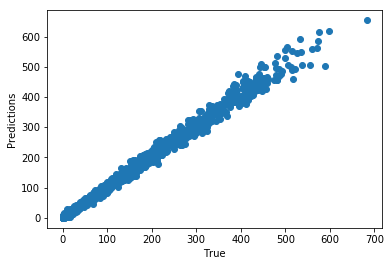

In [109]:
# Predicting test data for tuned DNN model

pred = model.predict(X_test).flatten()

# Plot predicted vs true labels

plt.scatter(y_test, pred)

plt.xlabel('True')
plt.ylabel('Predictions')
plt.show()

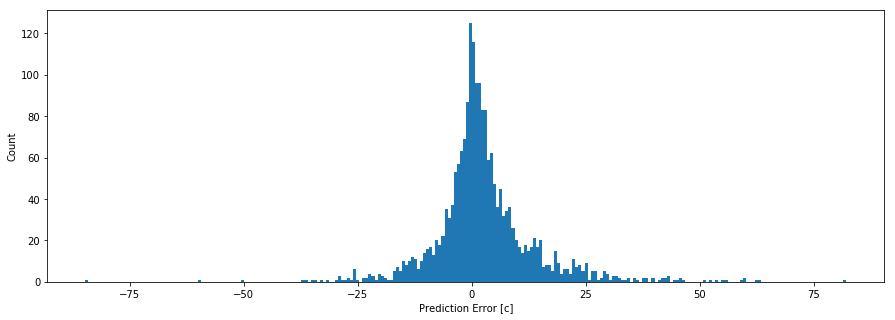

In [110]:
# Error histogram
plt.figure(figsize = [15,5])
error = pred - y_test
plt.hist(error, bins=250)
plt.xlabel('Prediction Error [c]')
_ = plt.ylabel('Count')

C:\Users\Rajit_Sanghvi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


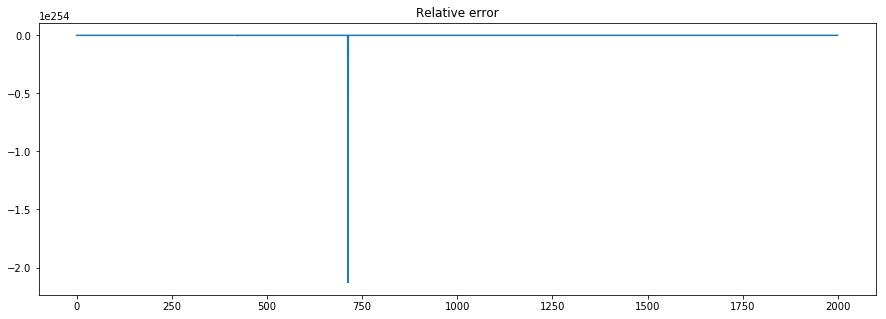

In [111]:
#Relative error
relative_error = np.divide(error,y_test)
plt.figure(figsize = [15,5])
plt.plot(relative_error)
plt.title("Relative error")
plt.show()

In [114]:
relative_error = pd.DataFrame(data=relative_error)

In [115]:
relative_error.describe()

,0
count,2.000000e+03
mean,-inf
std,NaN
min,-inf
25%,-3.502466e-02
50%,1.713557e-02
75%,6.911642e-02
max,2.731347e+154


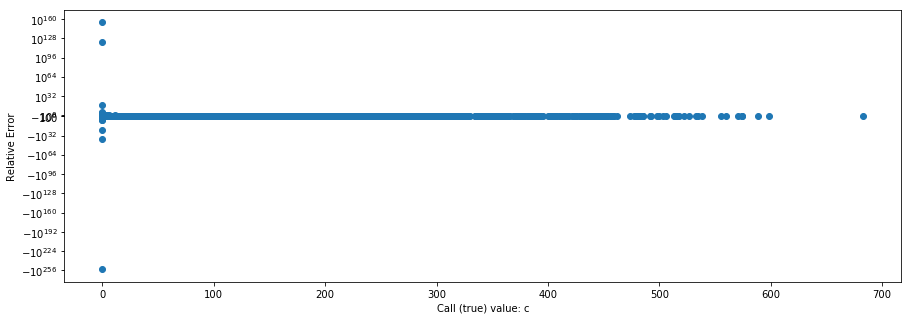

In [118]:
#Removing the infinite values

relative_error_corr = relative_error[abs(relative_error) != float("inf")]

#Plot relative error vs call value
plt.figure(figsize=[15, 5])
plt.scatter(y_test, relative_error_corr)
plt.ylabel("Relative Error")
plt.xlabel("Call (true) value: c")
plt.yscale("symlog")
plt.show()

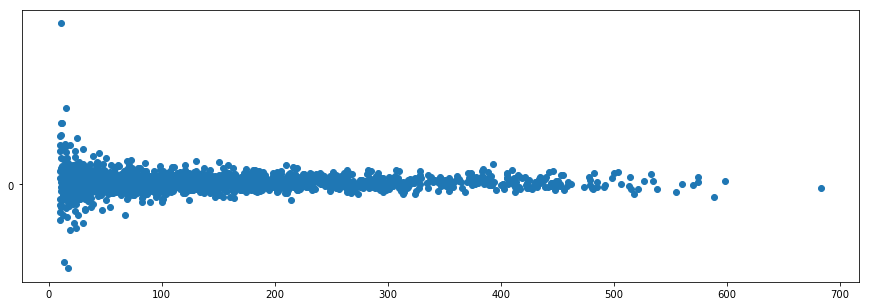

In [119]:
#Plot relative error vs call value for higher values of c
plt.figure(figsize=[15, 5])
plt.scatter(y_test[y_test >= 10], relative_error_corr[y_test >= 10])
plt.yscale("symlog")
plt.show()